In [1]:
import glob
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, time
import matplotlib.pyplot as plt
import os
import os.path
from time import perf_counter

df = pd.read_csv(f"/kaggle/input/cboedailytrimspxcboe202202020939/cboe_spx_2021_0dte_all.csv", index_col=None, header=0, dtype={'type':'category'})
df['expiration']=pd.to_datetime(df['expiration'],infer_datetime_format=True)
df['quote_date']=pd.to_datetime(df['quote_date'],infer_datetime_format=True)
df['delta'] = df['delta'].abs()


#########################
# Settings for backtest #
#########################
delta_sp = 0.214
delta_lp = None
delta_sc = None
delta_lc = None

same_day = True
purchase_time = '09:45:00'

# Max loss is % : max_loss * amount_collected is exit criteria
max_loss = 3.5

# In dollars
commission = 1.5

if same_day:
    dte_f = -1
else:
    dte_f = 0

initial_portfolio_value = 10000
    
is_spread = False
if (delta_sp is not None and delta_lp is None) or (delta_sp is not None and delta_lp is None):
    is_spread = True


In [2]:
df_ty = pd.read_csv(f"/kaggle/input/treasury-yield-13w-2012-2022/13_week_treasury_yield.csv", index_col=None, header=0)
df_ty['Date'] = pd.to_datetime(df_ty['Date'])

In [3]:
def get_contract_strike(curr_date, contract_date, target_delta, i_df):
    # -1 means no delta should be selected
    if target_delta ==-1:
        return pd.Series([0,0,0])
    
    df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date)].min()
    price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
    if np.isnan(price):
        return pd.Series([0,0,0])
    rounded_price = 5 * round(price / 5)
    return pd.Series([df1['strike'],df1['delta'],rounded_price])

def get_collected_from_strike(curr_date, contract_date, strike, i_df):   
    df1 = i_df[(i_df['quote_date']==curr_date) & (i_df['expiration']==contract_date) & (i_df['strike']==strike)].min()
    price = (df1['ask']+df1['bid'])/0.02 # 0.02 is dividing by two and multiplying by 100
    if np.isnan(price):
        return pd.Series([0,0,0])
    rounded_price = 5 * round(price / 5)
    return pd.Series([df1['strike'],df1['delta'],rounded_price])

def get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc):
    df1 = df[(df['quote_date']==contract_date) & (df['expiration']==contract_date) & (df['quote_time']=='16:00:00')].min()
    underlying = df1['price']
    total_lost = 0.0
    if strike_sc != 0.0:   
        if underlying > strike_sc:
            total_lost = total_lost + (underlying - strike_sc)*100
    if strike_lc != 0.0:
        if underlying > strike_lc:
            total_lost = total_lost - (underlying - strike_lc)*100
    if strike_sp != 0.0:
        if underlying < strike_sp:
            total_lost = total_lost + (strike_sp - underlying)*100
    if strike_lp != 0.0:
        if underlying < strike_lp:
            total_lost = total_lost - (strike_lp - underlying)*100
    return total_lost

def get_amount_lost_minute(contract_date, strike_sp, strike_lp, strike_sc, strike_lc, curr_collected, curr_lost, curr_comm, quote_time, trade_count, filtered_df):
    if curr_lost > 0.0:
        return pd.Series([trade_count, curr_lost, curr_comm])
    
    if (quote_time == '16:00:00'):
        return pd.Series([trade_count,get_amount_lost(contract_date, strike_sp, strike_lp, strike_sc, strike_lc), curr_comm])
    
    # TODO : change this line so quote date and expiration date can be different
    df1 = filtered_df[(filtered_df['quote_date']==contract_date) & (filtered_df['expiration']==contract_date)]
    
    if strike_sp == 0.0:
        bb_cost_sp = 0.0
    else:
        df_sp = df1[(df1['strike']==strike_sp) & (df1['type']=='P')].min()
        bb_cost_sp = (df_sp['ask']+df_sp['bid'])/0.02
    
    if strike_lp == 0.0:
        bb_cost_lp = 0.0
    else:
        df_lp = df1[(df1['strike']==strike_lp) & (df1['type']=='P')].min()
        bb_cost_lp = -1*(df_lp['ask']+df_lp['bid'])/0.02
    
    if strike_sc == 0.0:
        bb_cost_sc = 0.0
    else:
        df_sc = df1[(df1['strike']==strike_sc) & (df1['type']=='C')].min()
        bb_cost_sc = (df_sc['ask']+df_sc['bid'])/0.02
    
    if strike_lc == 0.0:
        bb_cost_lc = 0.0
    else:
        df_lc = df1[(df1['strike']==strike_lc)  & (df1['type']=='C')].min()
        bb_cost_lc = -1*(df_lc['ask']+df_lc['bid'])/0.02
        
    curr_cost_to_buy_back = bb_cost_sp + bb_cost_lp + bb_cost_sc + bb_cost_lc
    # return curr_value
    if curr_cost_to_buy_back > max_loss*curr_collected:
        pd.DataFrame([bb_cost_sp,bb_cost_lp,bb_cost_sc,bb_cost_lc,quote_time]).to_csv(f"{quote_time}_{contract_date}.csv")
        return pd.Series([trade_count+2,curr_cost_to_buy_back, curr_comm*2])
    
    return pd.Series([trade_count,0.0, curr_comm])

In [4]:
df_times = pd.DataFrame(df['quote_time'].unique())

df_trades = pd.DataFrame(df['expiration'].unique())
df_trades.rename({0: "expiration"}, axis='columns', inplace=True)
df_trades['trade_date'] = df_trades['expiration'].shift(1 + dte_f)
df_trades = df_trades[df_trades['trade_date'].isnull()==False]
df_trades['collected_sc'] = 0.0
df_trades['collected_lc'] = 0.0
df_trades['collected_sp'] = 0.0
df_trades['collected_lp'] = 0.0
df_trades['collected'] = 0.0
df_trades['lost'] = 0.0
df_trades['lost_put_spread'] = 0.0
df_trades['lost_call_spread'] = 0.0
df_trades['strike_sp'] = None
df_trades['strike_lp'] = None
df_trades['strike_sc'] = None
df_trades['strike_lc'] = None
df_trades['delta_sp'] = 0.0
df_trades['delta_lp'] = 0.0
df_trades['delta_sc'] = 0.0
df_trades['delta_lc'] = 0.0
df_trades['net'] = 0.0
df_trades['commission'] = 0.0
df_trades['portfolio_value'] = 0.0
df_trades['daily_return'] = 0.0
df_trades['margin_utilization']=0.0
df_trades['trade_count'] = 0

In [5]:
def populate_variable_delta_entry(strategy):
    df_var_delta = pd.DataFrame(df['expiration'].unique())
    df_var_delta.rename({0: "expiration"}, axis='columns', inplace=True)
    df_var_delta.set_index('expiration',inplace=True)
    df_var_delta['delta_sp_target'] = delta_sp
    df_var_delta['delta_lp_target'] = delta_lp
    df_var_delta['delta_sc_target'] = delta_sc
    df_var_delta['delta_lc_target'] = delta_lc
    df_var_delta['lp_offset'] = 20.0
    df_var_delta['lc_offset'] = 0.0
    df_var_delta.fillna(-1,inplace=True)
    return df_var_delta


In [6]:
start_time = perf_counter()
df_var_delta = populate_variable_delta_entry(None)
df = pd.merge(df, df_var_delta, left_on='expiration', right_index=True)
df_trades = pd.merge(df_trades, df_var_delta, left_on='expiration', right_index=True)
stop_time = perf_counter()
print(f"Elapsed : {stop_time - start_time}")

Elapsed : 2.5180106260000343


In [7]:
start_time = perf_counter()
# TODO, remove hardcoded 0
df_purchase_time = df[(df['quote_time'] == purchase_time) & (df['dte'] == 0)]

# create call/put dataframe slice if needed
df_c = df_purchase_time[(df_purchase_time['type']=="C")]
    
df_p = df_purchase_time[(df_purchase_time['type']=="P")]

# test if it's faster to iterate through rows and create dataframes or merge the minimum delta into the main dataframe and then delete

##### SHORT CALL #####
df_sc = df_c[(df_c['delta']<= df_c['delta_sc_target'])]
# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
df_sc = df_sc.loc[df_sc.groupby(['quote_date','dte'])[['delta']].idxmax()['delta']]
# Only keep the min expiration date for each quote
df_sc = df_sc.loc[df_sc.groupby('quote_date')[['dte']].idxmax()['dte']]
#apply dataframe to get strikes and collect premium
df_trades['strike_sc'],df_trades['delta_sc'],df_trades['collected_sc'] = df_trades.apply(
    lambda row : get_contract_strike(row['trade_date'], row['expiration'],row['delta_sc_target'], df_sc), axis = 1).T.values


#### SHORT PUT ####
df_sp = df_p[(df_p['delta']<= df_p['delta_sp_target'])]# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
# We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
df_sp = df_sp.loc[df_sp.groupby(['quote_date','dte'])[['delta']].idxmax()['delta']]
# Now that we're certain we have the minimum expiration date, get the minimum delta
df_sp = df_sp.loc[df_sp.groupby('quote_date')[['dte']].idxmax()['dte']]
df_trades['strike_sp'],df_trades['delta_sp'],df_trades['collected_sp'] = df_trades.apply(
    lambda row : get_contract_strike(row['trade_date'], row['expiration'],row['delta_sp_target'], df_sp), axis = 1).T.values


###### LONG CALL #####
if (df_trades['lc_offset'] > 0).all():
    df_trades['strike_lc'] = df_trades['strike_sc'] + df_trades['lc_offset']
    df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(
        lambda row : get_collected_from_strike(row['trade_date'], row['expiration'],row['strike_lc'], df_lc), axis = 1).T.values
    df_trades['collected_lc'] = df_trades['collected_lc']*-1
else:
    df_lc = df_c[(df_c['delta']>= df_c['delta_lc_target'])]# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    df_lc = df_lc.loc[df_lc.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Only keep the min expiration date for each quote
    df_lc = df_lc.loc[df_lc.groupby('quote_date')[['dte']].idxmin()['dte']]
    # apply dataframe to get strikes and collect premium
    df_trades['strike_lc'],df_trades['delta_lc'],df_trades['collected_lc'] = df_trades.apply(
        lambda row : get_contract_strike(row['trade_date'], row['expiration'],row['delta_lc_target'], df_c), axis = 1).T.values
    df_trades['collected_lc'] = df_trades['collected_lc']*-1


###### LONG PUT #####
if (df_trades['lp_offset'] > 0).all():
    df_trades['strike_lp'] = df_trades['strike_sp'] - df_trades['lp_offset']
    df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(
        lambda row : get_collected_from_strike(row['trade_date'], row['expiration'],row['strike_lp'], df_p), axis = 1).T.values
    df_trades['collected_lp']=df_trades['collected_lp']*-1
else:
    df_lp = df_p[(df_p['delta']>= df_p['delta_lp_target'])]# We don't know for certain how many expirations we have for a given quote date, so lets group on each and find min delta
    # We don't know for certain how many expirations we have for a given quote date, so only focus on the next one
    df_lp = df_lp.loc[df_lp.groupby(['quote_date','dte'])[['delta']].idxmin()['delta']]
    # Now that we're certain we have the minimum expiration date, get the minimum delta
    df_lp = df_lp.loc[df_lp.groupby('quote_date')[['dte']].idxmin()['dte']]
    df_trades['strike_lp'],df_trades['delta_lp'],df_trades['collected_lp'] = df_trades.apply(
        lambda row : get_contract_strike(row['trade_date'], row['expiration'],row['delta_lp_target'], df_lp), axis = 1).T.values
    df_trades['collected_lp']=df_trades['collected_lp']*-1

#TODO - clean this up. Short puts shouldn't ever be lower than long puts. 
# Likewise with long calls being lower than short calls. Need a better solution
for index, row in df_trades.iterrows():
    if row['strike_lp'] >= row['strike_sp'] and row['strike_sp'] > 0.0:
        df_trades.loc[index,'collected_lp'] = 0.0
        df_trades.loc[index,'collected_sp'] = 0.0
        df_trades.loc[index,'strike_lp'] = 0.0
        df_trades.loc[index,'strike_sp'] = 0.0
    if row['strike_sc'] >= row['strike_lc'] and row['strike_sc'] > 0.0:
        df_trades.loc[index,'collected_lc'] = 0.0
        df_trades.loc[index,'collected_sc'] = 0.0
        df_trades.loc[index,'strike_lc'] = 0.0
        df_trades.loc[index,'strike_sc'] = 0.0
    if df_trades.loc[index,'strike_lc'] > 0.0:
        df_trades.loc[index,'trade_count']+=1
    if df_trades.loc[index,'strike_sc'] > 0.0:
        df_trades.loc[index,'trade_count']+=1
    if df_trades.loc[index,'strike_lp'] > 0.0:
        df_trades.loc[index,'trade_count']+=1
    if df_trades.loc[index,'strike_sp'] > 0.0:
        df_trades.loc[index,'trade_count']+=1
        

df_trades['collected'] = df_trades['collected_sc'] + df_trades['collected_lc'] + df_trades['collected_sp'] + df_trades['collected_lp']
df_trades['commission'] = df_trades['trade_count'] * commission

#TODO Drop target columns from df
df_trades.drop(columns=['delta_sp_target','delta_lp_target','delta_sc_target','delta_lc_target','lp_offset','lc_offset'], inplace=True)
df.drop(columns=['delta_sp_target','delta_lp_target','delta_sc_target','delta_lc_target'], inplace=True)

print(f"Elapsed time : {perf_counter() - start_time}")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


Elapsed time : 3.2171221819999687


In [8]:
start_time_timer = perf_counter()
for index, trow in df_times.iterrows():
    min_i = int(trow[0][3:5])
    curr_time = time(hour=int(trow[0][0:2]),minute=int(trow[0][3:5]),second=int(trow[0][6:]))
    start_time = time(hour=9, minute=45)
    end_time = time(hour=16)
    if (end_time < curr_time or curr_time <= start_time):
        continue
    filtered_df = df[(df['quote_time']==str(trow[0]))]
    
    # TODO: make lost a combination of 'lost_put_spread' and 'lost_call_spread'
    df_trades['trade_count'],df_trades['lost'], df_trades['commission'] = df_trades.apply(lambda row : get_amount_lost_minute(row['expiration'], row['strike_sp'], row['strike_lp'], row['strike_sc'], row['strike_lc'], row['collected'], row['lost'], row['commission'], str(trow[0]), row['trade_count'], filtered_df), axis=1).T.values
    
    stop_time_timer = perf_counter()
    # print(df_trades.head())
    
    if min_i % 30 == 0:
        print(f"Processed {curr_time} | Elapsed : {stop_time_timer - start_time_timer}")
        start_time_timer = stop_time_timer

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:58: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Processed 10:00:00 | Elapsed : 20.706402773000036
Processed 10:30:00 | Elapsed : 40.27781935899998
Processed 11:00:00 | Elapsed : 38.933289183
Processed 11:30:00 | Elapsed : 38.49724389900001
Processed 12:00:00 | Elapsed : 38.18910744000004
Processed 12:30:00 | Elapsed : 36.79783938899993
Processed 13:00:00 | Elapsed : 36.471760097000015
Processed 13:30:00 | Elapsed : 36.769867516999966
Processed 14:00:00 | Elapsed : 37.28443564999998
Processed 14:30:00 | Elapsed : 37.09150968600011
Processed 15:00:00 | Elapsed : 36.508902659
Processed 15:30:00 | Elapsed : 35.665646636999895


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


Processed 16:00:00 | Elapsed : 107.06652029700001


In [9]:
df_trades['net'] = df_trades['collected'] - df_trades['lost'] - df_trades['commission']
df_trades['portfolio_value'] = 0.0
#df_trades['daily_return'] = 0.0
#df_trades['margin_utilization']=0.0
initial_portfolio_value = 10000
df_trades['net_cumsum']=df_trades['net'].cumsum()

df_trades['portfolio_value'] = initial_portfolio_value + df_trades['net_cumsum']
df_trades['transaction_return'] = df_trades['net'] / df_trades['portfolio_value'].shift(1)
df_trades['transaction_return'].iloc[0] = df_trades['net'].iloc[0] / initial_portfolio_value

df_trades['cum_return'] = (df_trades['portfolio_value'] - initial_portfolio_value) / initial_portfolio_value

df_ty['daily_risk_free_return'] = (df_ty['Adj Close'] / 252) / 100
df_ty.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1, inplace=True)

df_trades = pd.merge(df_trades, df_ty, left_on='trade_date', right_on='Date')
df_trades.drop(['Date'],axis=1,inplace=True)
df_trades.head()

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,lost_put_spread,lost_call_spread,...,net,commission,portfolio_value,daily_return,margin_utilization,trade_count,net_cumsum,transaction_return,cum_return,daily_risk_free_return
0,2021-01-04,2021-01-04,0,0,305.0,-120.0,185.0,655.0,0.0,0.0,...,-476.0,6.0,9524.0,0.0,0.0,4.0,-476.0,-0.047600,-0.0476,0.000003
1,2021-01-06,2021-01-06,0,0,405.0,-225.0,180.0,0.0,0.0,0.0,...,177.0,3.0,9701.0,0.0,0.0,2.0,-299.0,0.018585,-0.0299,0.000003
2,2021-01-08,2021-01-08,0,0,330.0,-150.0,180.0,795.0,0.0,0.0,...,-621.0,6.0,9080.0,0.0,0.0,4.0,-920.0,-0.064014,-0.0920,0.000003
3,2021-01-11,2021-01-11,0,0,370.0,-180.0,190.0,0.0,0.0,0.0,...,187.0,3.0,9267.0,0.0,0.0,2.0,-733.0,0.020595,-0.0733,0.000003
4,2021-01-13,2021-01-13,0,0,330.0,-140.0,190.0,0.0,0.0,0.0,...,187.0,3.0,9454.0,0.0,0.0,2.0,-546.0,0.020179,-0.0546,0.000003


In [10]:
df_trades.iloc[24:].head(50)

,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,lost_put_spread,lost_call_spread,...,net,commission,portfolio_value,daily_return,margin_utilization,trade_count,net_cumsum,transaction_return,cum_return,daily_risk_free_return
24,2021-03-01,2021-03-01,0,0,380.0,-180.0,200.0,0.0,0.0,0.0,...,197.0,3.0,9834.0,0.0,0.0,2.0,-166.0,0.020442,-0.01660,1.111111e-06
25,2021-03-03,2021-03-03,0,0,525.0,-270.0,255.0,53.0,0.0,0.0,...,199.0,3.0,10033.0,0.0,0.0,2.0,33.0,0.020236,0.00330,1.388889e-06
26,2021-03-05,2021-03-05,0,0,705.0,-415.0,290.0,0.0,0.0,0.0,...,287.0,3.0,10320.0,0.0,0.0,2.0,320.0,0.028606,0.03200,1.111111e-06
27,2021-03-08,2021-03-08,0,0,560.0,-310.0,250.0,0.0,0.0,0.0,...,247.0,3.0,10567.0,0.0,0.0,2.0,567.0,0.023934,0.05670,1.388889e-06
28,2021-03-10,2021-03-10,0,0,405.0,-195.0,210.0,0.0,0.0,0.0,...,207.0,3.0,10774.0,0.0,0.0,2.0,774.0,0.019589,0.07740,1.190476e-06
29,2021-03-12,2021-03-12,0,0,350.0,-140.0,210.0,0.0,0.0,0.0,...,207.0,3.0,10981.0,0.0,0.0,2.0,981.0,0.019213,0.09810,9.920635e-07
30,2021-03-15,2021-03-15,0,0,255.0,-90.0,165.0,0.0,0.0,0.0,...,162.0,3.0,11143.0,0.0,0.0,2.0,1143.0,0.014753,0.11430,5.952381e-07
31,2021-03-17,2021-03-17,0,0,495.0,-240.0,255.0,0.0,0.0,0.0,...,252.0,3.0,11395.0,0.0,0.0,2.0,1395.0,0.022615,0.13950,3.174603e-07
32,2021-03-19,2021-03-19,0,0,460.0,-235.0,225.0,0.0,0.0,0.0,...,222.0,3.0,11617.0,0.0,0.0,2.0,1617.0,0.019482,0.16170,1.984127e-07
33,2021-03-22,2021-03-22,0,0,250.0,-90.0,160.0,0.0,0.0,0.0,...,157.0,3.0,11774.0,0.0,0.0,2.0,1774.0,0.013515,0.17740,1.984127e-07


In [11]:

                                                                                         
# if you want to scale the chart, you should do it here
factor = 1.0
df_trade_plot = df_trades.copy()
df_trade_plot['net'] = df_trade_plot['net']*factor
df_trade_plot.set_index('expiration', inplace=True)
df_trade_plot = df_trade_plot['net'].cumsum()

In [12]:
df[(df['expiration']=='2020-02-28') & (df['quote_date']=='2020-02-28') & (df['strike']==2810)].to_csv('2810.csv')

In [13]:
df_trades.iloc[24:].head(50)

,expiration,trade_date,collected_sc,collected_lc,collected_sp,collected_lp,collected,lost,lost_put_spread,lost_call_spread,...,net,commission,portfolio_value,daily_return,margin_utilization,trade_count,net_cumsum,transaction_return,cum_return,daily_risk_free_return
24,2021-03-01,2021-03-01,0,0,380.0,-180.0,200.0,0.0,0.0,0.0,...,197.0,3.0,9834.0,0.0,0.0,2.0,-166.0,0.020442,-0.01660,1.111111e-06
25,2021-03-03,2021-03-03,0,0,525.0,-270.0,255.0,53.0,0.0,0.0,...,199.0,3.0,10033.0,0.0,0.0,2.0,33.0,0.020236,0.00330,1.388889e-06
26,2021-03-05,2021-03-05,0,0,705.0,-415.0,290.0,0.0,0.0,0.0,...,287.0,3.0,10320.0,0.0,0.0,2.0,320.0,0.028606,0.03200,1.111111e-06
27,2021-03-08,2021-03-08,0,0,560.0,-310.0,250.0,0.0,0.0,0.0,...,247.0,3.0,10567.0,0.0,0.0,2.0,567.0,0.023934,0.05670,1.388889e-06
28,2021-03-10,2021-03-10,0,0,405.0,-195.0,210.0,0.0,0.0,0.0,...,207.0,3.0,10774.0,0.0,0.0,2.0,774.0,0.019589,0.07740,1.190476e-06
29,2021-03-12,2021-03-12,0,0,350.0,-140.0,210.0,0.0,0.0,0.0,...,207.0,3.0,10981.0,0.0,0.0,2.0,981.0,0.019213,0.09810,9.920635e-07
30,2021-03-15,2021-03-15,0,0,255.0,-90.0,165.0,0.0,0.0,0.0,...,162.0,3.0,11143.0,0.0,0.0,2.0,1143.0,0.014753,0.11430,5.952381e-07
31,2021-03-17,2021-03-17,0,0,495.0,-240.0,255.0,0.0,0.0,0.0,...,252.0,3.0,11395.0,0.0,0.0,2.0,1395.0,0.022615,0.13950,3.174603e-07
32,2021-03-19,2021-03-19,0,0,460.0,-235.0,225.0,0.0,0.0,0.0,...,222.0,3.0,11617.0,0.0,0.0,2.0,1617.0,0.019482,0.16170,1.984127e-07
33,2021-03-22,2021-03-22,0,0,250.0,-90.0,160.0,0.0,0.0,0.0,...,157.0,3.0,11774.0,0.0,0.0,2.0,1774.0,0.013515,0.17740,1.984127e-07


In [14]:
def net2pct(x):
    return (x / initial_portfolio_value)*100


def pct2net(x):
    return initial_portfolio_value * x/100



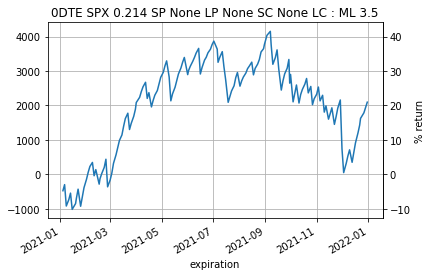

In [15]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
secax = ax.secondary_yaxis('right', functions=(net2pct, pct2net))
secax.set_ylabel('% return')
df_trade_plot.plot(ax=ax)
plt.title(f"{'0' if same_day else '1-2'}DTE SPX {delta_sp} SP {delta_lp} LP {delta_sc} SC {delta_lc} LC : ML {max_loss}")
plt.grid()
plt.savefig(f"{'0' if same_day else '1-2'}DTE_SPX_{delta_sp}SP_{delta_lp}LP_{delta_sc}SC_{delta_lc}LC_IC.png")

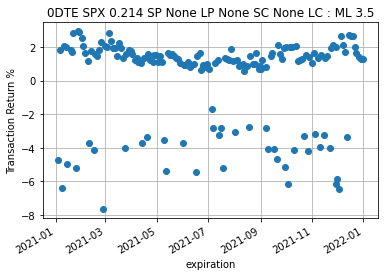

In [16]:
df_trades_transaction_return = df_trades.copy()
df_trades_transaction_return['transaction_return'] *= 100 
df_trades_transaction_return.set_index('expiration', inplace=True)
fig = plt.figure()
ax = df_trades_transaction_return['transaction_return'].plot(linestyle='None', marker="o")
ax.set_ylabel('Transaction Return %')
plt.title(f"{'0' if same_day else '1-2'}DTE SPX {delta_sp} SP {delta_lp} LP {delta_sc} SC {delta_lc} LC : ML {max_loss}")
plt.grid()
plt.savefig(f"{'0' if same_day else '1-2'}DTE_SPX_{delta_sp}SP_{delta_lp}LP_{delta_sc}SC_{delta_lc}LC_IC.png")

In [17]:
trade_count = df_trades.shape[0]
win_count = df_trades[df_trades['net']>0].shape[0]
loss_count = df_trades[df_trades['net']<0].shape[0]
std_trans_return = df_trades['transaction_return'].std()
std_trans_return_less_rf = (df_trades['transaction_return'] - df_trades['daily_risk_free_return']).std()
print("*****  BACKTEST RESULTS  ****")
print(
    f"\n{'Cumulative return:':<35}{round(df_trades['cum_return'].iloc[-1]*100,3):>10} %",
    f"\n{'Max Drawdown:':<35}{round(df_trades['cum_return'].min()*100,3):>10} %",
    
    f"\n{'Trading Days:':<35}{trade_count:>10}",
    f"\n{'Wins:':<35}{win_count:>10}",
    f"\n{'Losses:':<35}{loss_count:>10}",
    f"\n{'Breakeven:':<35}{df_trades[df_trades['net']==0.0].shape[0]:>10}",
    f"\n{'Win/Loss Ratio:':<35}{round(win_count/trade_count*100,3):>10} %",
    f"\n{'Mean Win:':<35}{round(df_trades[df_trades['net']>0]['net'].mean(),3):>10} $",
    f"\n{'Mean Win Trans Return:':<35}{round(df_trades[df_trades['transaction_return']>0]['transaction_return'].mean()*100,3):>10} %",
    f"\n{'Mean Loss:':<35}{round(df_trades[df_trades['net']<0]['net'].mean(),3):>10} $",
    f"\n{'Mean Loss Trans Return:':<35}{round(df_trades[df_trades['transaction_return']<0]['transaction_return'].mean()*100,3):>10} %",
    f"\n{'Mean Net Trans:':<35}{round(df_trades['net'].mean(),3):>10} $",
    f"\n{'Mean Trans Return:':<35}{round(df_trades['transaction_return'].mean()*100,3):>10} %",
    f"\n{'Std Dev of Net Trans:':<35}{round(df_trades['net'].std(),3):>10}",
    f"\n{'Std Dev of Trans Return:':<35}{round(df_trades['transaction_return'].std(),3):>10}",
    f"\n{'Max Loss:':<35}{round(df_trades['net'].min(),3):>10} $",
    f"\n{'Max Win:':<35}{round(df_trades['net'].max(),3):>10} $",
    f"\n{'Sharpe Ratio static STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return,3):>10}",
    f"\n{'Sharpe Ratio with RF STD:':<35}{round(np.sqrt(252)*(df_trades['transaction_return'].mean()-df_trades['daily_risk_free_return'].mean())/std_trans_return_less_rf,3):>10}",

)



*****  BACKTEST RESULTS  ****

Cumulative return:                     20.945 % 
Max Drawdown:                          -10.17 % 
Trading Days:                             159 
Wins:                                     121 
Losses:                                    38 
Breakeven:                                  0 
Win/Loss Ratio:                        76.101 % 
Mean Win:                              179.14 $ 
Mean Win Trans Return:                  1.545 % 
Mean Loss:                           -515.303 $ 
Mean Loss Trans Return:                -4.275 % 
Mean Net Trans:                        13.173 $ 
Mean Trans Return:                      0.154 % 
Std Dev of Net Trans:                 307.528 
Std Dev of Trans Return:                0.026 
Max Loss:                              -801.0 $ 
Max Win:                                292.0 $ 
Sharpe Ratio static STD:                0.938 
Sharpe Ratio with RF STD:               0.938
